# Project 2

## Łukasz Andryszewski

### 151930

In [1]:
%matplotlib inline
import numpy as np
import os
import hashlib
import deap
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [2]:
N = 2000
MESSAGE_LENGTH = 256
messages = [np.unpackbits(np.frombuffer(os.urandom(MESSAGE_LENGTH),dtype=np.uint8)) for _ in range(N)]
INPUT_BITS_SIZE = 32*8
bits_to_flip = np.sort(np.random.choice(np.arange(MESSAGE_LENGTH*8), size=INPUT_BITS_SIZE, replace=False))

In [3]:
def flip_bit(bit_message, i):
    #flipped = bit_message.copy()
    flipped = bit_message
    flipped[i] ^= 1
    return flipped

In [4]:
def hash_message(bit_message):
    h = hashlib.sha256()
    h.update(np.packbits(bit_message))
    return np.unpackbits(np.frombuffer(h.digest(),dtype=np.uint8))

# Part A - SAC (Strict Avalanche Criterion)

In [5]:
def sac_test(messages, bits_to_flip, hash_message):
    out = []
    for i in bits_to_flip:
        bit_out = []
        for msg in messages:
            y = hash_message(msg)
            msg_copy = msg.copy()
            y_prime = hash_message(flip_bit(msg_copy, i))

            delta = y ^ y_prime
            bit_out.append(delta)
        bit_out = np.array(bit_out)
        out.append(bit_out)
    out = np.array(out)
    return out.transpose(1,0,2)  # shape (N, INPUT_BITS_SIZE, OUTPUT_BITS_SIZE)

In [6]:
out = sac_test(messages, bits_to_flip, hash_message)

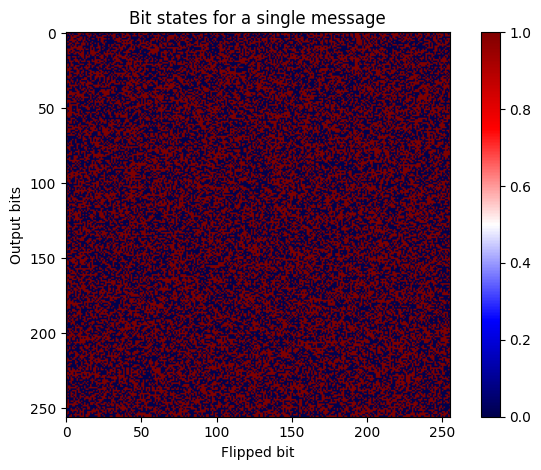

In [7]:
cmap = "seismic"
a = out[0,:,:]
plt.imshow(a,vmin=0,vmax=1, cmap=cmap)
plt.title("Bit states for a single message")
plt.xlabel("Flipped bit")
plt.ylabel("Output bits")
plt.tight_layout()
plt.colorbar()
plt.show()

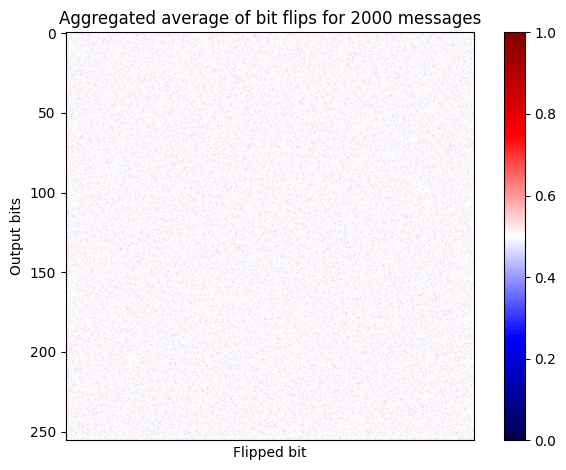

In [8]:
a = np.mean(out, axis=0)
plt.imshow(a,vmin=0,vmax=1, cmap=cmap)
plt.title(f"Aggregated average of bit flips for {N} messages")
plt.xlabel("Flipped bit")
# plt.xticks(
#     ticks=np.arange(INPUT_BITS_SIZE),
#     labels=bits_to_flip,
#     rotation=90)
plt.xticks([])
plt.ylabel("Output bits")
plt.tight_layout()
plt.colorbar()
plt.show()

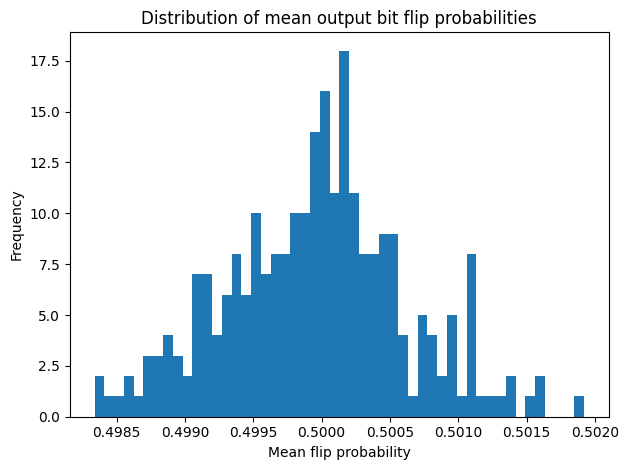

In [9]:
out_stats = ({
    "mean":out.mean(axis=(0,1)),
    "std":out.std(axis=(0,1))
    })

plt.hist(out_stats["mean"], bins=50)
plt.title("Distribution of mean output bit flip probabilities")
plt.xlabel("Mean flip probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

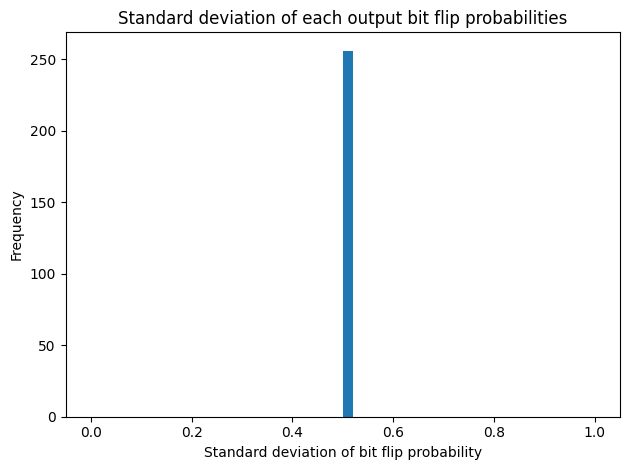

In [98]:
plt.hist(np.round(out_stats["std"],3), bins=50)
plt.title("Standard deviation of each output bit flip probabilities")
plt.xlabel("Standard deviation of bit flip probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [10]:
def bad_hash32(msg: bytes) -> bytes:
    msg = np.packbits(msg).tobytes()
    state = bytearray(32)

    for i, b in enumerate(msg):
        state[i % 32] = (state[i % 32] + b + i) % 256

    for i in range(32):
        state[i] = (state[i] ^ (state[(i - 1) % 32] + i)) % 256

    return np.unpackbits(np.frombuffer(bytes(state),dtype=np.uint8))

In [11]:
out_bad = sac_test(messages, bits_to_flip, bad_hash32)

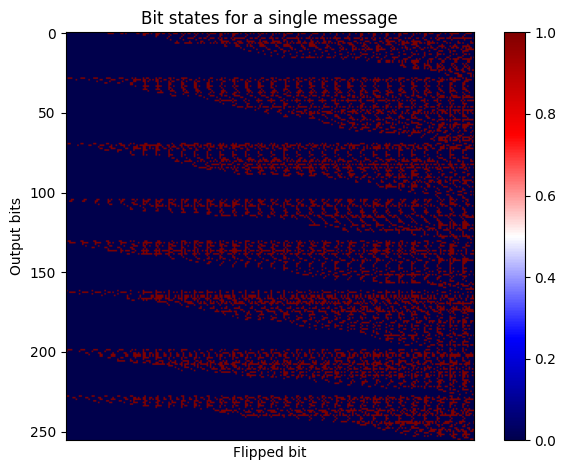

In [12]:
cmap = "seismic"
a = out_bad[0,:,:]
plt.imshow(a,vmin=0,vmax=1, cmap=cmap)
plt.title("Bit states for a single message")
plt.xlabel("Flipped bit")
plt.xticks([])
plt.ylabel("Output bits")
plt.tight_layout()
plt.colorbar()
plt.show()

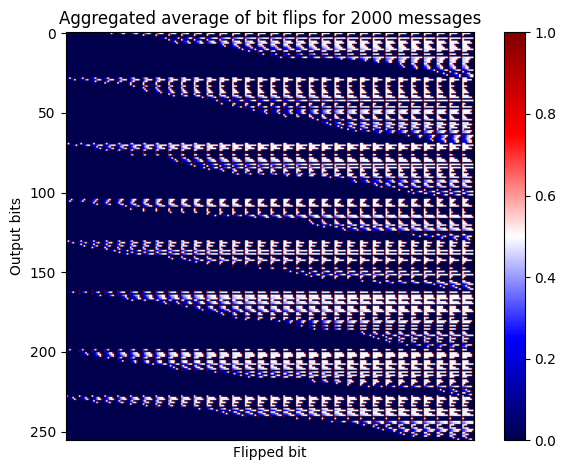

In [13]:
a = np.mean(out_bad, axis=0)
plt.imshow(a,vmin=0,vmax=1, cmap=cmap)
plt.title(f"Aggregated average of bit flips for {N} messages")
plt.xlabel("Flipped bit")
plt.xticks([])
plt.ylabel("Output bits")
plt.tight_layout()
plt.colorbar()
plt.show()

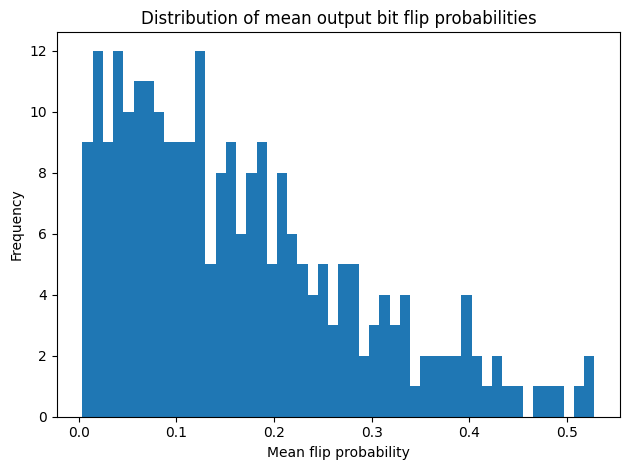

In [14]:
out_stat_bad = pd.DataFrame({
    "mean":out_bad.mean(axis=(0,1)),
    "std":out_bad.std(axis=(0,1))
    })

plt.hist(out_stat_bad["mean"], bins=50)
plt.title("Distribution of mean output bit flip probabilities")
plt.xlabel("Mean flip probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

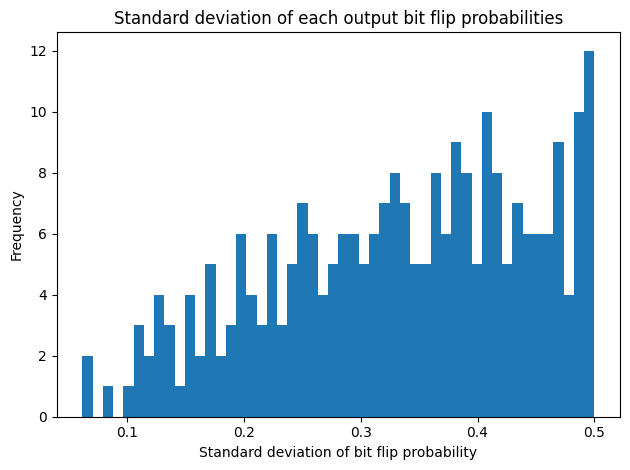

In [99]:
plt.hist(np.round(out_stat_bad["std"],3), bins=50)
plt.title("Standard deviation of each output bit flip probabilities")
plt.xlabel("Standard deviation of bit flip probability")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Part B - BIC (Bit Independence Criterion)

In [15]:
def bic_test(delta, bits):
    out = np.ones((len(bits), delta.shape[2], delta.shape[2]))
    n,m,p = delta.shape

    for bi,i in enumerate(bits):
        out_bits = delta[:,i,:]
        for j in range(p):
            for k in range(j+1,p):
                if delta[:,i,j].std() == 0 or delta[:,i,k].std() == 0:
                    coef = 0
                else:
                    coef = np.corrcoef(delta[:,i,j],delta[:,i,k])[0,1]
                out[bi,j,k] = coef
                out[bi,k,j] = coef
    return out

In [16]:
bit_independence = np.random.choice(
    np.arange(len(bits_to_flip)), size=1, replace=False)

In [17]:
bic_out = bic_test(out, bit_independence)

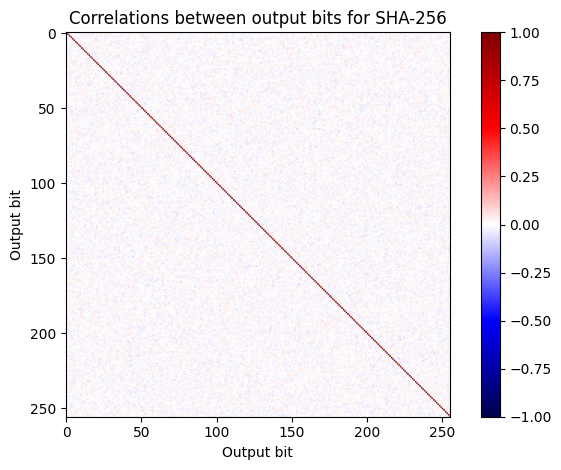

In [18]:
plt.imshow(bic_out[0,:,:],vmin=-1,vmax=1, cmap=cmap)
plt.title(f"Correlations between output bits for SHA-256")
plt.xlabel("Output bit")
plt.ylabel("Output bit")
plt.tight_layout()
plt.colorbar()
plt.show()

In [19]:
bic_out_bad = bic_test(out_bad, bit_independence)

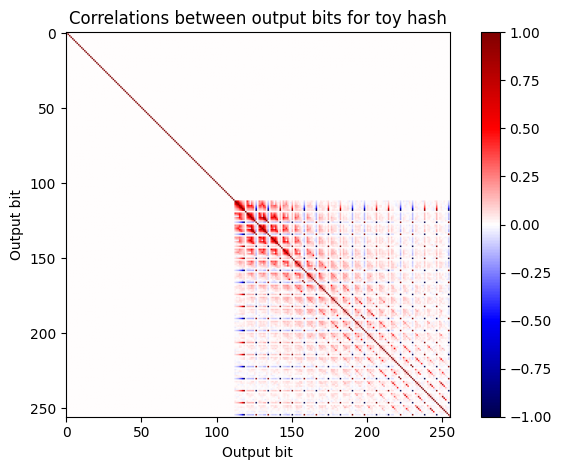

In [27]:
plt.imshow(bic_out_bad[0,:,:],vmin=-1,vmax=1, cmap=cmap)
plt.title(f"Correlations between output bits for toy hash")
plt.xlabel("Output bit")
plt.ylabel("Output bit")
plt.tight_layout()
plt.colorbar()
plt.show()

# Part C - Near Collisions

In [21]:
import random
from deap import base, creator, tools, algorithms

VERBOSE=False
logs = {}
rest = {}

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

individual_length = 32
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, individual_length * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def hamming_distance(individual, hashing_function):
    length = len(individual)
    x, y = individual[:length//2], individual[length//2:]
    if x == y:
        return 99999, # avoid trivial solutions
    x, y = hashing_function(x), hashing_function(y)
    return np.sum(x ^ y),

toolbox.register("evaluate", hamming_distance, hashing_function=hash_message)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


population = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)
method="SHA256_EA"
rest[method], logs[method] = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=1000, stats=stats, halloffame=hof, verbose=VERBOSE)

In [ ]:
toolbox.register("evaluate", hamming_distance, hashing_function=bad_hash32)
method="ToyHash_EA"
rest[method], logs[method] = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=1000, stats=stats, halloffame=hof, verbose=VERBOSE)

In [34]:
def localSearch(individual, toolbox, stats=None, halloffame=None, verbose=True):
    population = [individual]
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    gen = 1
    while True:
        improvement = False 

        nevals = 0
        for move in toolbox.neighbors(individual):
            new_individual = toolbox.clone(individual)
            new_individual = toolbox.apply_move(new_individual, move)
            fitness = toolbox.evaluate(new_individual)
            nevals += 1
            new_individual.fitness.values = fitness
            if fitness[0] < individual.fitness.values[0]:
                improvement = True
                break

        if halloffame is not None:
            halloffame.update([individual])
        
        record = stats.compile([individual]) if stats else {}
        logbook.record(gen=gen, nevals=nevals, **record)
        if verbose:
            print(logbook.stream)
        
        gen += 1
        if not improvement:
            break
        else:
            individual = new_individual

    return individual, logbook

In [61]:
toolbox.register("neighbors", lambda ind: range(len(ind)))
toolbox.register("apply_move", flip_bit)
toolbox.register("evaluate", hamming_distance, hashing_function=bad_hash32)
method="ToyHash_LS"
rest[method], logs[method] = localSearch(toolbox.individual(), toolbox, stats=stats, verbose=VERBOSE)

In [54]:
toolbox.register("evaluate", hamming_distance, hashing_function=hash_message)
method="SHA256_LS"
rest[method], logs[method] = localSearch(toolbox.individual(), toolbox, stats=stats, verbose=VERBOSE)

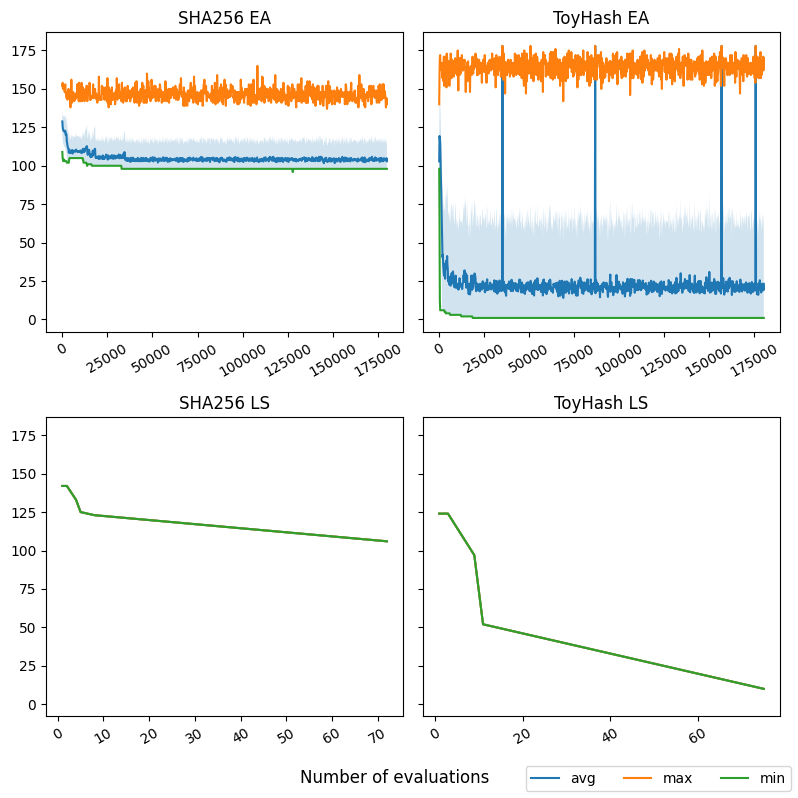

In [92]:
methods = ["EA","LS"]
hashes = ["SHA256", "ToyHash"]

fig, axs = plt.subplots(2,2,figsize=(8,8),sharey=True)
for method_name,ax1 in zip(methods, axs):
    for hash_name, ax in zip(hashes, ax1):
        name = f"{hash_name}_{method_name}"
        min_ = logs[name].select("min")
        max_ = np.array(logs[name].select("max"))
        non_invalid_max = np.max(max_[max_!=99999])
        max_ = np.clip(max_,0,a_max=non_invalid_max)
        avg_ = np.clip(logs[name].select("avg"),0,non_invalid_max)
        std_ = logs[name].select("std")
        #h,a = method.split("_")
        evals = np.cumsum(logs[name].select("nevals"))
        ax.plot(evals, avg_, label="avg")
        ax.plot(evals, max_, label="max")
        ax.plot(evals, min_, label="min")
        ax.fill_between(evals, np.clip(np.array(avg_)-np.array(std_),min=min_), np.clip(np.array(avg_)+np.array(std_),max=max_), alpha=0.2)
        ax.set_title(f"{hash_name} {method_name}")
        ax.tick_params(axis='x', labelrotation=30)
fig.supxlabel("Number of evaluations")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right",ncol=3)
fig.tight_layout()
plt.show()

In [122]:
pd.DataFrame({name: [min(log.select("min"))] for name, log in logs.items()}).T.rename(columns={0:"Min"}).T

,SHA256_EA,ToyHash_EA,ToyHash_LS,SHA256_LS
Min,96.0,1.0,10.0,106.0


# Raport 

## SAC

For SHA256, all probabilities of bit flips were around 50%. This indicates very strong hashing ability of the SHA256 standard. In comparison for the implemented toy hash, many bits had very small or very high probabilities and the heatmap also showed clear patterns.

## BIC

For SHA256 the correlations between bits flips were exactly 0 and the toy hash showed clear patterns. For the toy hash clear patterns in data were visible.

## Finding near collisions

Two algorithms were used to find near collisions in the hash functions:

- Evolutionary algorithm
- Local search

The solutions were represented as two bit messages concatenated into a single bitstring. To evaluate them a hamming distance between their hashes was calculated. The objective is to minimize this distance in order to find two inputs that almost collide. Exact inputs were penalized.

For the evolutionary algorithm, bit flipping was used as a mutation operator. As crossover operator the Two Point Crossover was used.

In local search the neighbourhood was defined similarly as in EA - as any solution with a flipped bit.

The near collisions Toy hash can be easily found, as indicated by the result of 1 achieved by EA. This cannot be said for the SHA256, for which neither methods were able to find any significant collisions - hamming distance 96 for EA and 106 for LS. Expected happing distance for two messages of length 256, would be 128 -> exactly 50%.

This is exactly the behaviour one would expect for a strong hash like SHA256, because collisions in hash functions undermine their purpose. As such any search method should not find it in reasonable time.